## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [22]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [23]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    valid_Actions = []
    
    # created a seperate method in the env class to know agent's valid action
    valid_Actions = list(env.agent_actions(state)) ###### -------please call your environment as env
    return valid_Actions

In [24]:
# Defining a function which will add new Q-values to the Q-dictionary. 
'''Added the additional parameter state_string rather than calling the Q-state function inside this function.
This enables us to find the state_string inside the loop once and use it in for the Q-update equation as well.
This has been done to optimise the time taken to run the Q-update loop
'''
def add_to_dict(state, state_string):    
    valid_act = valid_actions(state)
    if state_string not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_string][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [25]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, state_string, episode_number):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0000012*episode_number)
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[state_string],key=Q_dict[state_string].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        agent_actions = valid_actions(state)
        action = random.choice(agent_actions)    #Exploration: randomly choosing and action
    
    return action

### Epsilon - decay check

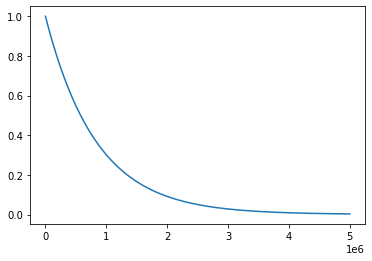

In [26]:
# visaulising the epsilon-decay vs the episodes. We are uing the 5M episodes.
# This epsilon decay strategy choosen after tuning the hyperparameters
epsilon_demo = []
time_stamp = np.arange(0,5000000)
min_epsilon_d = 0.001
max_epsilon_d = 1.0
for i in range(0,5000000):
    epsilon_demo.append(min_epsilon_d + (max_epsilon_d - min_epsilon_d) * np.exp(-0.0000012*i))
plt.plot(time_stamp, epsilon_demo)
plt.show()

#### Tracking the state-action pairs for checking convergence - write your code here

In [27]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

In [28]:
# Initialise states to be tracked
'''We are initializing the states_track with the 0s and the length equal to the number of episodes.
This will enable us to index and add the state values rather than appending to the list. And there by optimize the time 
taken to run the Q-update loop'''
def initialise_tracking_states(num_of_episodes):
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(0, 9)),
                       ('x-x-x-x-x-x-x-x-x',(2, 9)),
                       ('x-x-9-x-x-x-x-x-8',(1, 5)),
                       ('x-x-9-x-6-x-x-x-x',(5, 5))]#select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [0]*num_of_episodes

In [29]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [30]:
# function to save the tracking states
# gets the current episode number and adds the q-value at that index rather than appending.
def save_tracking_states(current_ep):
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action][current_ep] = Q_dict[state][action]

In [31]:
# initializing the tracking states
EPISODES = 5000000
initialise_tracking_states(EPISODES)

#### Define hyperparameters  ---write your code here

In [32]:
# These values have been choosen after multiple iterations 
LR = 0.05
GAMMA = 0.91

### Q-update loop ---write your code here

In [33]:
start_time = time.time()
rewards = [0]*EPISODES
number_of_wins = 0
for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    # initializing the environment
    env = TicTacToe()
    
    # initial state
    curr_state = env.state 
    curr_state_string = Q_state(curr_state)
    add_to_dict(curr_state, curr_state_string)
    
    #initialising the parameters
    time_step = 0
    total_reward = 0
    terminate = False
    
    while not(terminate):
        #finding the agent action using the epsilon_greedy method
        curr_action = epsilon_greedy(curr_state, curr_state_string, episode)
        
        # calling the step method in env class to know the reward and next state
        next_state, reward, terminate, agent_win = env.step(curr_state, curr_action)
        next_state_string = Q_state(next_state)
        add_to_dict(next_state, next_state_string)

        # UPDATE RULE
        if not(terminate): # non-terminal state
            max_next = max(Q_dict[next_state_string],key=Q_dict[next_state_string].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_string][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_string][max_next]))) - Q_dict[curr_state_string][curr_action] )
        else: # terminal state - if the game terminates, next state q value is 0
            Q_dict[curr_state_string][curr_action] += LR * (reward + - Q_dict[curr_state_string][curr_action] )
        
        # updating the parameters for the next iteration and adding the rewards
        curr_state = next_state
        curr_state_string = next_state_string
        total_reward += reward
    
    # Saving the tracking states, rewards and counting the agent wins
    #save_tracking_states(episode)
    rewards[episode] = total_reward
    if agent_win > 0:
        number_of_wins+=1

    
elapsed_time = time.time() - start_time
print("Time taken to run the Q-update loop is",elapsed_time,"seconds")
save_obj(States_track,'States_tracked')

Time taken to run the Q-update loop is 3634.9059584140778 seconds


In [34]:
#Printing the winning percentage
number_of_wins/EPISODES*100

78.3562

As we saw above, we are getting the winning % around 78. And we can say that RL model is doing a good job here.

#### Check the Q-dictionary

In [35]:
# printing the Q-dict 
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 1.9834329024553272,
              (0, 3): 1.4382784316162975,
              (0, 5): -0.38942759157233087,
              (0, 7): 1.5170345327634127,
              (0, 9): 2.34435942406706,
              (1, 1): 0.03378146133389567,
              (1, 3): -0.47177995806467793,
              (1, 5): 4.731338953330487,
              (1, 7): -0.6480628358664445,
              (1, 9): 0.54369064212946,
              (2, 1): 1.3349850110552572,
              (2, 3): 1.8362135631655812,
              (2, 5): -0.6720332905306788,
              (2, 7): 1.5815433555737373,
              (2, 9): 1.220919753571913,
              (3, 1): 0.1364882870844871,
              (3, 3): 0.6073423266771806,
              (3, 5): 0.13834886085120646,
              (3, 7): 0.08528534116434057,
              (3, 9): -0.09810591941233411,
              (4, 1): 0.9070063299329704,
              (4, 3): 1.1644390641214957,
              (4, 5): -1.4940249

In [36]:
# length of the Q-dict
len(Q_dict)

1584897

In [37]:
# printing the avg reward of the 1M and last 1M episodes
first_1M = rewards[0:1000000]
print("Average of the first 1M episodes reward",sum(first_1M)/len(first_1M))
last_1M = rewards[4000000:]
print("Average of the first 1M episodes reward",sum(last_1M)/len(last_1M))

Average of the first 1M episodes reward -2.912941
Average of the first 1M episodes reward 6.098791


As we see above, the avg reward for the first 1M epsiodes is around -3 and the avg reward for the last 1M episodes is around 6. So our model is exploring enough in the initial stage and exploiting the learnings in the later stages of the episodes

In [38]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
state_to_be_checked = 'x-8-x-x-x-9-x-x-x'
max(Q_dict[state_to_be_checked],key=Q_dict[state_to_be_checked].get)

(8, 5)

#### Check the states tracked for Q-values convergence
(non-evaluative)

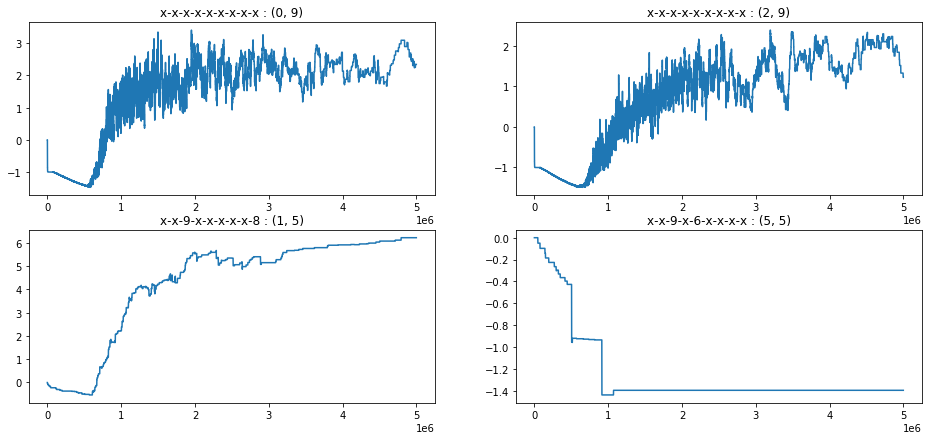

In [39]:
# Code for plotting the graphs for state-action pairs tracked
plot_num = 1
plt.figure(0, figsize=(16,7))
for state in States_track.keys():
    for action in States_track[state].keys():
        plt.subplot(2, 2, plot_num)
        plt.plot(States_track[state][action])
        plt.title(state+' : '+str(action))
        plot_num+=1

From above plots, we can see that the states are reaching the convergence as the episodes are increasing